# T1 Mapping using pymp2rage

In [1]:
# Calculates a quantitative T1 mapping from MP2RAGE data
import os
import json
import matplotlib.pyplot as plt
import pymp2rage
import nibabel as nib
from nilearn import plotting
import numpy as np

## Load data

In [2]:
# Load dataset paths
# Load dataset paths
subject = '334264'
scan = '401-x-WIPMP2RAGE_0p7mm_1sTI_best_oneSENSE-x-WIPMP2RAGE_0p7mm_1sTI_best_oneSENSE'
scan_num = '401'
scan_times = ['1010', '3310']
dataset_path = '/nfs/masi/saundam1/outputs/mp2rage_converted_v2023/'
subject_path = os.path.join(dataset_path, subject, scan)

# Load NIFTI files
inv1_real = nib.load(os.path.join(subject_path, f'{scan_num}_real_t{scan_times[0]}.nii'))
inv1_imag = nib.load(os.path.join(subject_path, f'{scan_num}_imaginary_t{scan_times[0]}.nii'))
inv2_real = nib.load(os.path.join(subject_path, f'{scan_num}_real_t{scan_times[1]}.nii'))
inv2_imag = nib.load(os.path.join(subject_path, f'{scan_num}_imaginary_t{scan_times[1]}.nii'))

## Load JSON

In [3]:
# Load JSON
inv1_json_path = os.path.join(subject_path, f'{scan_num}_t{scan_times[0]}.json')
inv2_json_path = os.path.join(subject_path, f'{scan_num}_t{scan_times[1]}.json')
with open(inv1_json_path, 'r') as f1, open(inv2_json_path, 'r') as f2:
    inv1_json = json.load(f1)
    inv2_json = json.load(f2)

## Create complex data

In [4]:
# Load data from NIFTI
inv1_real_data = inv1_real.get_fdata()
inv1_imag_data = inv1_imag.get_fdata()
inv2_real_data = inv2_real.get_fdata()
inv2_imag_data = inv2_imag.get_fdata()

# Create combined complex data
inv1_data = inv1_real_data + 1j*inv1_imag_data
inv2_data = inv2_real_data + 1j*inv2_imag_data

# Create phase and magnitude NIFTIs from this data
inv1_mag = np.abs(inv1_data)
inv1_ph = np.angle(inv1_data)
inv2_mag = np.abs(inv2_data)
inv2_ph = np.angle(inv2_data)

inv1_mag_nifti = nib.nifti2.Nifti2Image(inv1_mag, inv1_real.affine)
inv1_ph_nifti = nib.nifti2.Nifti2Image(inv1_ph, inv1_real.affine)
inv2_mag_nifti = nib.nifti2.Nifti2Image(inv2_mag, inv2_real.affine)
inv2_ph_nifti = nib.nifti2.Nifti2Image(inv2_ph, inv2_real.affine)

## Load acquisition parameters

In [5]:
# Load acquisition parameters
MPRAGE_tr = 8.25
nZslices = [112.5, 112.5]
FLASH_tr = [inv1_json['RepetitionTime'], inv2_json['RepetitionTime']]
invtimesAB = [inv1_json['TriggerDelayTime'], inv2_json['TriggerDelayTime']]
flipangleABdegree =[inv1_json['FlipAngle'], inv2_json['FlipAngle']]
sequence = 'normal'
inversion_efficiency = 0.84 # estimate
B0 = inv1_json['MagneticFieldStrength']

# Create MP2RAGE object
fitter = pymp2rage.MP2RAGE(
        MPRAGE_tr=MPRAGE_tr,
        nZslices=nZslices,
        FLASH_tr=FLASH_tr,
        invtimesAB=invtimesAB,
        flipangleABdegree=flipangleABdegree,
        sequence=sequence,
        inversion_efficiency=inversion_efficiency,
        B0=B0,
        inv1=inv1_mag_nifti,
        inv1ph=inv1_ph_nifti,
        inv2=inv2_mag_nifti,
        inv2ph=inv2_ph_nifti,
    )

## Plot T1-weighted image

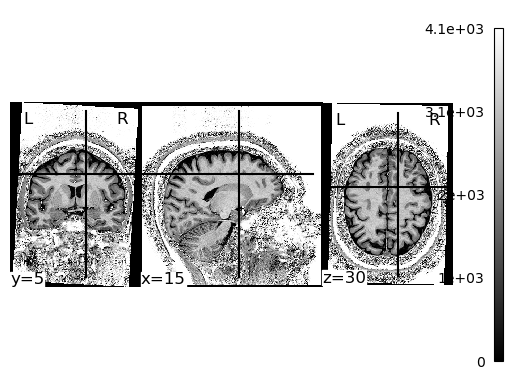

In [6]:
# Plot T1w image
fig, ax = plt.subplots()
plotting.plot_img(fitter.t1w_uni, cut_coords=(15, 5, 30), cmap='gray', axes=ax, colorbar=True)

# Save
fitter.t1w_uni.to_filename('outputs/example_t1w_uni.nii')

## Plot T1 map

In [ ]:
# Plot T1 map
fig, ax = plt.subplots()
plotting.plot_img(fitter.t1map, cut_coords=(15, 5, 30), cmap='gray', axes=ax, colorbar=True)